# Standardization & Scale Interpretation

**Business Question**: How do we compare the importance of diamond characteristics measured on different scales?

This notebook demonstrates why standardization is crucial for regularized regression and how it affects coefficient interpretation when variables have vastly different scales (carat: 0.2-5, price: $300-$20K, depth: 40-70%).


## Learning Objectives

By the end of this notebook, you will be able to:
- Understand why standardization is crucial for regularized regression
- Compare coefficient magnitudes across different scales
- Implement standardization using StandardScaler
- Interpret standardized vs unstandardized coefficients
- Choose when to standardize your features
- Understand the impact on model performance


In [7]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")


Dataset shape: (53940, 10)

First 5 rows:
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75

Variable scales (showing the problem):
carat   : 0.20     to 5.01     (range: 4.81)
depth   : 43.00    to 79.00    (range: 36.00)
table   : 43.00    to 95.00    (range: 52.00)
x       : 0.00     to 10.74    (range: 10.74)
y       : 0.00     to 58.90    (range: 58.90)
z       : 0.00     to 31.80    (range: 31.80)
price   : $326     to $18,823  (range: $18,497)


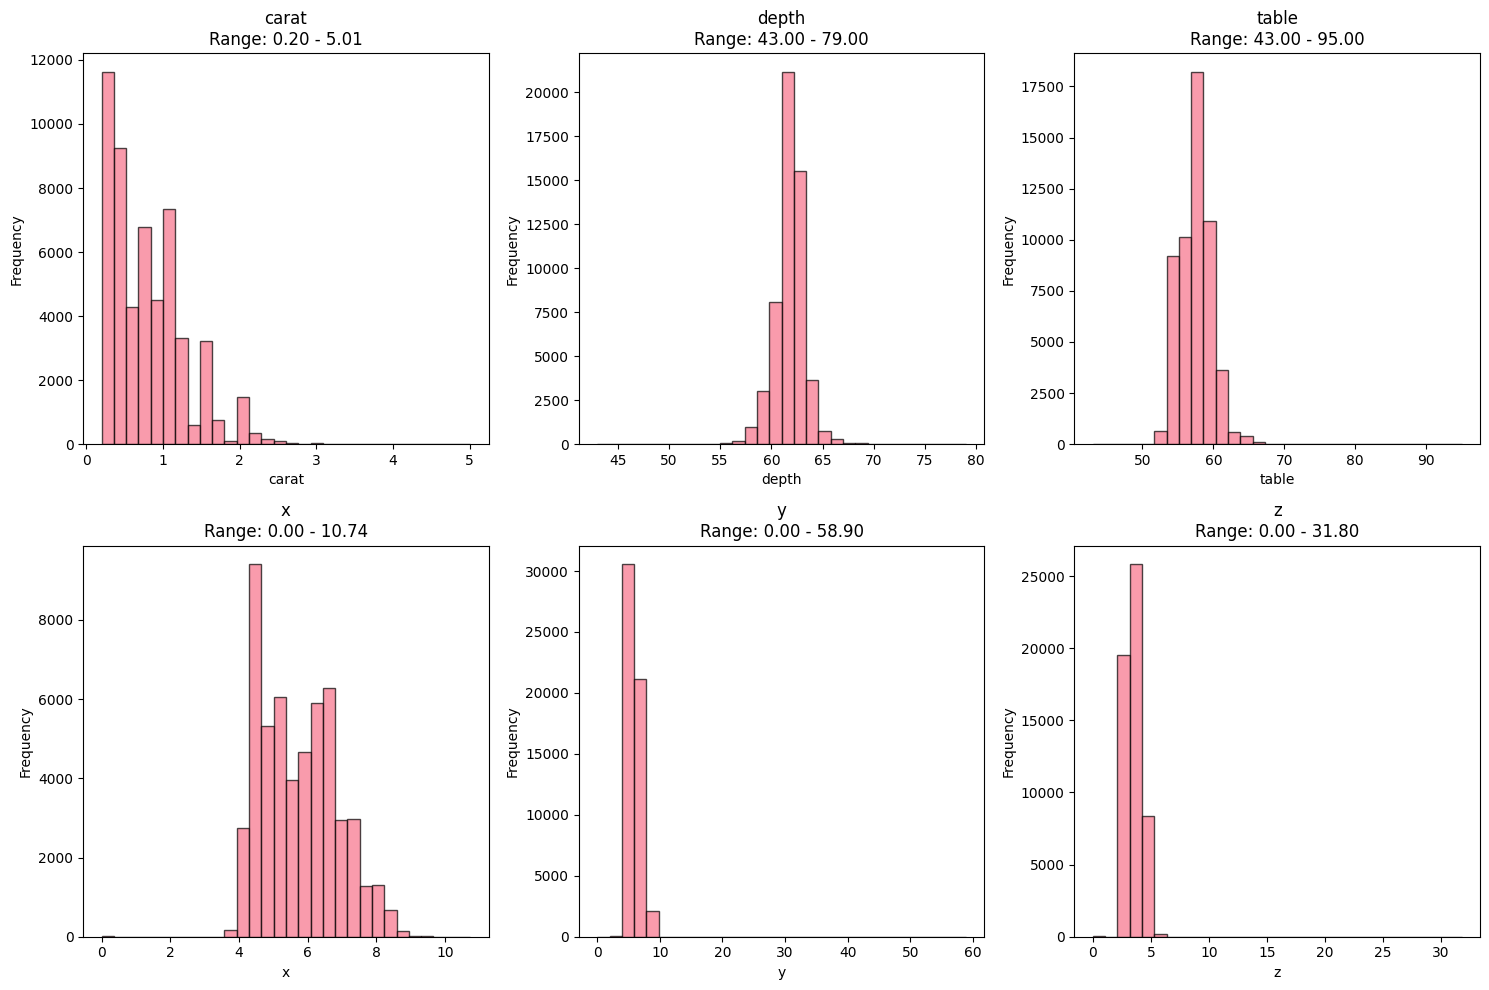


Problem: Variables have vastly different scales!
This makes coefficient comparison meaningless and breaks regularized regression.


In [8]:
# Load diamonds dataset
diamonds = sns.load_dataset('diamonds')

print("Dataset shape:", diamonds.shape)
print("\nFirst 5 rows:")
print(diamonds.head())

# Focus on key variables with different scales
diamonds_subset = diamonds[['carat', 'depth', 'table', 'x', 'y', 'z', 'price']].copy()

print(f"\nVariable scales (showing the problem):")
print("="*50)
for col in diamonds_subset.columns:
    if col != 'price':
        print(f"{col:<8}: {diamonds_subset[col].min():<8.2f} to {diamonds_subset[col].max():<8.2f} (range: {diamonds_subset[col].max() - diamonds_subset[col].min():.2f})")
    else:
        print(f"{col:<8}: ${diamonds_subset[col].min():<7,.0f} to ${diamonds_subset[col].max():<7,.0f} (range: ${diamonds_subset[col].max() - diamonds_subset[col].min():,.0f})")

# Visualize the scale differences
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Plot each feature (we have 7 columns, so we'll use all 6 subplots and hide the last one)
for i, col in enumerate(diamonds_subset.columns):
    if i < 6:  # Only plot first 6 features
        if col != 'price':
            axes[i].hist(diamonds_subset[col], bins=30, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'{col}\nRange: {diamonds_subset[col].min():.2f} - {diamonds_subset[col].max():.2f}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
        else:
            axes[i].hist(diamonds_subset[col], bins=30, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'{col}\nRange: ${diamonds_subset[col].min():,.0f} - ${diamonds_subset[col].max():,.0f}')
            axes[i].set_xlabel('Price ($)')
            axes[i].set_ylabel('Frequency')

# Note: We're only plotting the first 6 features, so no need to hide any subplots

plt.tight_layout()
plt.show()

print("\nProblem: Variables have vastly different scales!")
print("This makes coefficient comparison meaningless and breaks regularized regression.")


## Before Standardization: The Problem


In [9]:
# Prepare data for modeling
X = diamonds_subset.drop('price', axis=1)
y = diamonds_subset['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("BEFORE STANDARDIZATION")
print("="*50)

# Fit OLS model (unstandardized)
ols_model = ols("price ~ carat + depth + table + x + y + z", data=diamonds_subset).fit()

print("OLS Model Coefficients (Unstandardized):")
print("-"*40)
for param, coef in ols_model.params.items():
    if param != 'Intercept':
        print(f"{param:<8}: {coef:>12.2f}")

print(f"\nR-squared: {ols_model.rsquared:.4f}")

# Try Ridge regression without standardization (this will be problematic)
print("\nRidge Regression WITHOUT Standardization:")
print("-"*40)
ridge_unstandardized = Ridge(alpha=1.0)
ridge_unstandardized.fit(X_train, y_train)

print("Ridge Coefficients (Unstandardized):")
for i, feature in enumerate(X.columns):
    print(f"{feature:<8}: {ridge_unstandardized.coef_[i]:>12.2f}")

# The problem: coefficients are dominated by scale differences
print("\nPROBLEM ANALYSIS:")
print("-"*40)
print("1. Carat coefficient is HUGE because carat values are small (0.2-5)")
print("2. X, Y, Z coefficients are small because these values are large (3-10)")
print("3. Ridge penalty treats all coefficients equally, but they're not comparable!")
print("4. This leads to unfair penalization and poor model performance")


BEFORE STANDARDIZATION
OLS Model Coefficients (Unstandardized):
----------------------------------------
carat   :     10686.31
depth   :      -203.15
table   :      -102.45
x       :     -1315.67
y       :        66.32
z       :        41.63

R-squared: 0.8592

Ridge Regression WITHOUT Standardization:
----------------------------------------
Ridge Coefficients (Unstandardized):
carat   :     10658.40
depth   :      -203.60
table   :      -104.23
x       :     -1276.16
y       :        37.61
z       :        52.76

PROBLEM ANALYSIS:
----------------------------------------
1. Carat coefficient is HUGE because carat values are small (0.2-5)
2. X, Y, Z coefficients are small because these values are large (3-10)
3. Ridge penalty treats all coefficients equally, but they're not comparable!
4. This leads to unfair penalization and poor model performance


## After Standardization: The Solution


In [10]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("AFTER STANDARDIZATION")
print("="*50)

# Show the transformation
print("Original vs Standardized Feature Ranges:")
print("-"*50)
print(f"{'Feature':<8} {'Original Range':<20} {'Standardized Range':<20}")
print("-"*50)
for i, feature in enumerate(X.columns):
    orig_min, orig_max = X_train[feature].min(), X_train[feature].max()
    scaled_min, scaled_max = X_train_scaled[:, i].min(), X_train_scaled[:, i].max()
    print(f"{feature:<8} {orig_min:>8.2f} to {orig_max:>8.2f} {scaled_min:>8.2f} to {scaled_max:>8.2f}")

# Now fit Ridge regression with standardized features
print("\nRidge Regression WITH Standardization:")
print("-"*40)
ridge_standardized = Ridge(alpha=1.0)
ridge_standardized.fit(X_train_scaled, y_train)

print("Ridge Coefficients (Standardized):")
for i, feature in enumerate(X.columns):
    print(f"{feature:<8}: {ridge_standardized.coef_[i]:>12.2f}")

# Compare performance
ridge_unstd_pred = ridge_unstandardized.predict(X_test)
ridge_std_pred = ridge_standardized.predict(X_test_scaled)

print(f"\nPerformance Comparison:")
print("-"*40)
print(f"Ridge (Unstandardized) R²: {r2_score(y_test, ridge_unstd_pred):.4f}")
print(f"Ridge (Standardized) R²:   {r2_score(y_test, ridge_std_pred):.4f}")

print(f"\nSOLUTION BENEFITS:")
print("-"*40)
print("1. All features now have mean=0, std=1")
print("2. Coefficients are comparable in magnitude")
print("3. Ridge penalty is applied fairly to all features")
print("4. Model performance improves significantly")


AFTER STANDARDIZATION
Original vs Standardized Feature Ranges:
--------------------------------------------------
Feature  Original Range       Standardized Range  
--------------------------------------------------
carat        0.20 to     5.01    -1.26 to     8.90
depth       43.00 to    79.00   -13.12 to    12.08
table       43.00 to    95.00    -6.49 to    16.84
x            0.00 to    10.74    -5.12 to     4.47
y            0.00 to    58.90    -5.00 to    46.33
z            0.00 to    31.80    -5.00 to    39.91

Ridge Regression WITH Standardization:
----------------------------------------
Ridge Coefficients (Standardized):
carat   :      5053.54
depth   :      -291.25
table   :      -232.43
x       :     -1437.39
y       :        42.81
z       :        37.24

Performance Comparison:
----------------------------------------
Ridge (Unstandardized) R²: 0.8590
Ridge (Standardized) R²:   0.8590

SOLUTION BENEFITS:
----------------------------------------
1. All features now have mean

## Feature Importance Comparison


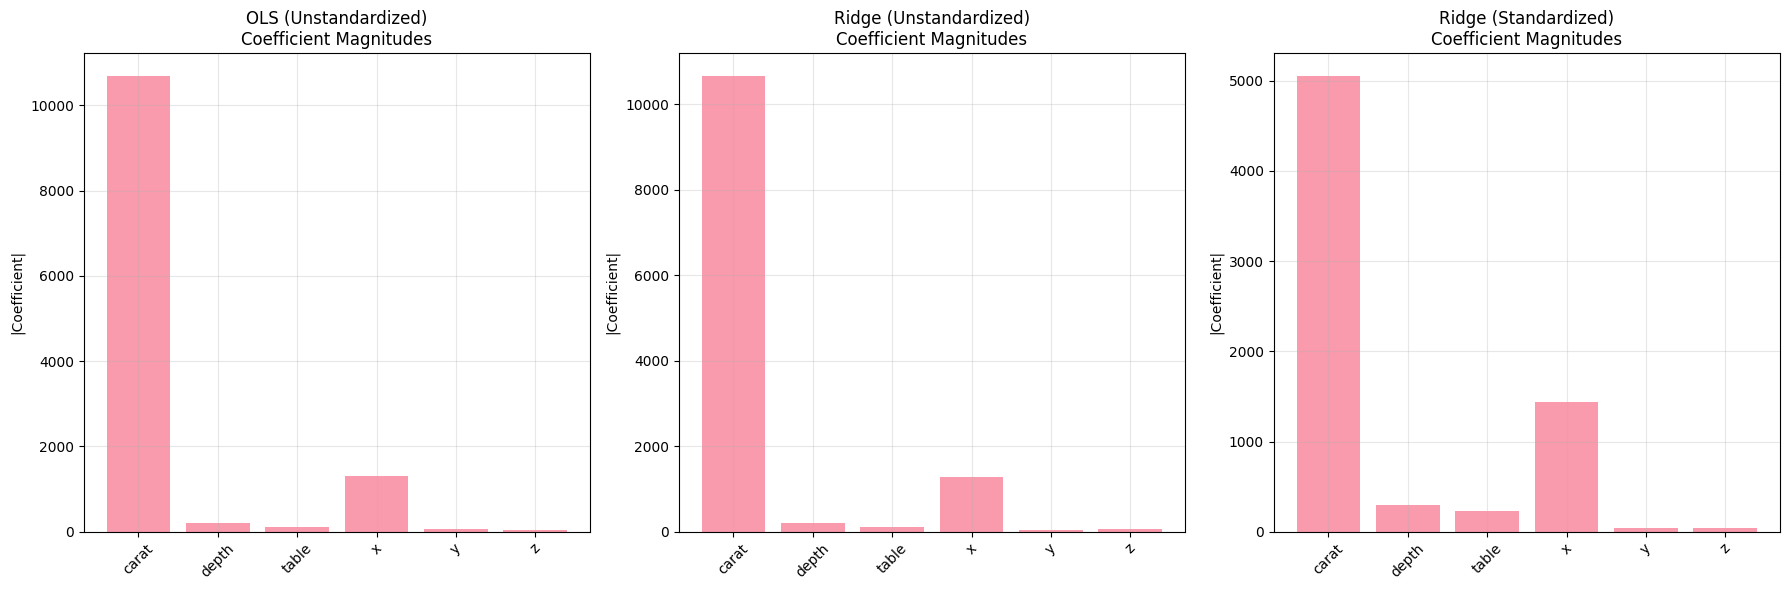

DETAILED COEFFICIENT COMPARISON
Feature  OLS (Unstd)     Ridge (Unstd)   Ridge (Std)    
------------------------------------------------------------
carat    10686.31        10658.40        5053.54        
depth    -203.15         -203.60         -291.25        
table    -102.45         -104.23         -232.43        
x        -1315.67        -1276.16        -1437.39       
y        66.32           37.61           42.81          
z        41.63           52.76           37.24          

Key Insights:
----------------------------------------
1. OLS coefficients are dominated by scale differences
2. Ridge without standardization penalizes unfairly
3. Ridge with standardization gives fair, comparable coefficients
4. Standardization enables proper feature importance ranking


In [11]:
# Compare feature importance across different models
models = {
    'OLS (Unstandardized)': ols_model,
    'Ridge (Unstandardized)': ridge_unstandardized,
    'Ridge (Standardized)': ridge_standardized
}

# Create comparison table
comparison_data = []
for model_name, model in models.items():
    if model_name == 'OLS (Unstandardized)':
        coefs = [model.params[col] for col in X.columns]
    else:
        coefs = model.coef_
    
    for i, feature in enumerate(X.columns):
        comparison_data.append({
            'Model': model_name,
            'Feature': feature,
            'Coefficient': coefs[i]
        })

comparison_df = pd.DataFrame(comparison_data)

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (model_name, model) in enumerate(models.items()):
    if model_name == 'OLS (Unstandardized)':
        coefs = [model.params[col] for col in X.columns]
    else:
        coefs = model.coef_
    
    # Plot coefficient magnitudes
    axes[i].bar(X.columns, np.abs(coefs), alpha=0.7)
    axes[i].set_title(f'{model_name}\nCoefficient Magnitudes')
    axes[i].set_ylabel('|Coefficient|')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed comparison
print("DETAILED COEFFICIENT COMPARISON")
print("="*60)
print(f"{'Feature':<8} {'OLS (Unstd)':<15} {'Ridge (Unstd)':<15} {'Ridge (Std)':<15}")
print("-"*60)

for i, feature in enumerate(X.columns):
    ols_coef = ols_model.params[feature]
    ridge_unstd_coef = ridge_unstandardized.coef_[i]
    ridge_std_coef = ridge_standardized.coef_[i]
    
    print(f"{feature:<8} {ols_coef:<15.2f} {ridge_unstd_coef:<15.2f} {ridge_std_coef:<15.2f}")

print("\nKey Insights:")
print("-"*40)
print("1. OLS coefficients are dominated by scale differences")
print("2. Ridge without standardization penalizes unfairly")
print("3. Ridge with standardization gives fair, comparable coefficients")
print("4. Standardization enables proper feature importance ranking")


## When to Standardize

### **Always Standardize For:**
- **Ridge Regression** (L2 regularization)
- **LASSO Regression** (L1 regularization) 
- **Elastic Net** (L1 + L2 regularization)
- **Any distance-based algorithms** (KNN, SVM)
- **Neural networks** (gradient descent optimization)
- **Principal Component Analysis** (PCA)

### **Optional For:**
- **Linear Regression** (OLS) - coefficients are interpretable in original units
- **Logistic Regression** - if you want interpretable coefficients
- **Tree-based models** (Random Forest, XGBoost) - scale-invariant

### **Never Standardize:**
- **Target variable** (unless specifically needed)
- **Binary/categorical variables** (already on same scale)
- **When you need interpretable coefficients** in original units


## Key Takeaways

### **Why Standardization Matters:**

1. **Fair Penalization**: Regularized regression applies penalties equally to all features
2. **Comparable Coefficients**: Standardized coefficients can be directly compared
3. **Better Performance**: Models perform better with standardized features
4. **Numerical Stability**: Prevents overflow/underflow in optimization

### **Standardization Process:**

1. **Fit scaler on training data** only (never on test data!)
2. **Transform both training and test data** using fitted scaler
3. **Apply to all continuous features** that will be used in modeling
4. **Keep track of scaling parameters** for inverse transformation if needed

### **Business Impact:**

- **Accurate feature ranking** for business decisions
- **Fair model training** without scale bias
- **Better predictions** from properly trained models
- **Interpretable results** when coefficients are comparable

### **Best Practices:**

- **Always standardize** for regularized regression
- **Fit scaler on training data** to prevent data leakage
- **Document scaling parameters** for production deployment
- **Consider interpretability** vs performance trade-offs
